In [4]:
import spotipy
import spotipy.util as util
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np

# Prepare Data

In [5]:
# import 1000 Songs csv
# url = 'https://drive.google.com/file/d/1dyA3rDvuK9BjtQp-CnydzpLd9qaBN_Wo/view?usp=sharing'
# path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
# df_1000_songs = pd.read_csv(path)

# df_1000_songs

# import 5000 Songs csv
url = 'https://drive.google.com/file/d/1EShXt1NialMUz1ydWnz9Icywqb0_TBw6/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df_5000_songs = pd.read_csv(path)

df_5000_songs

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.6580,0.25900,11,-13.141,0,0.0705,0.694,0.000059,0.9750,0.3060,110.376,,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.7420,0.39900,2,-12.646,1,0.0346,0.217,0.000002,0.1070,0.6930,125.039,,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.8510,0.73000,2,-11.048,1,0.3470,0.453,0.000063,0.1240,0.9050,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...
3,Mulher Eu Sei ...,Chico César,0.7050,0.05020,4,-18.115,1,0.0471,0.879,0.000041,0.3860,0.5240,106.802,,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...
4,Rosa Morena ...,Kurt Elling,0.6510,0.11900,6,-19.807,1,0.0380,0.916,0.000343,0.1040,0.4020,120.941,,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,0.2020,0.06940,3,-23.390,1,0.0473,0.917,0.715000,0.0832,0.0655,87.906,,995000,4,1aEhYlZtypmipA06SDJ4U3,https://open.spotify.com/track/1aEhYlZtypmipA0...
5231,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,0.1880,0.10100,6,-21.873,1,0.0442,0.855,0.426000,0.0694,0.0355,83.134,,855000,4,1Gfqe7TAKklmuZf6hxsH6h,https://open.spotify.com/track/1Gfqe7TAKklmuZf...
5232,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,0.0596,0.00093,9,-42.959,1,0.0434,0.951,0.969000,0.0772,0.0344,71.573,,238187,3,2XNwnFrdMDpismp0VUZ7cU,https://open.spotify.com/track/2XNwnFrdMDpismp...
5233,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,0.1330,0.02080,4,-29.443,1,0.0419,0.883,0.505000,0.1110,0.0591,67.109,,314307,4,7ucDwgMtE3YJtEfTbuRhy0,https://open.spotify.com/track/7ucDwgMtE3YJtEf...


In [6]:
# clean data

df_5000_songs.columns = ['name', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'duration_ms', 'time_signature', 'id', 'html']
songs_x = df_5000_songs[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

In [7]:
# transform data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
songs_x_norm = pd.DataFrame(scaler.fit_transform(songs_x))
songs_x_norm

,0,1,2,3,4,5,6,7,8
0,0.680455,0.25900,0.763897,0.076797,0.696787,0.000060,0.987842,0.310660,0.515800
1,0.767322,0.39900,0.771967,0.037691,0.217871,0.000002,0.108409,0.703553,0.584322
2,0.880041,0.73000,0.798018,0.377996,0.454819,0.000064,0.125633,0.918782,0.437862
3,0.729059,0.05020,0.682811,0.051307,0.882530,0.000041,0.391084,0.531980,0.499098
4,0.673216,0.11900,0.655228,0.041394,0.919679,0.000348,0.105370,0.408122,0.565171
...,...,...,...,...,...,...,...,...,...
5230,0.208893,0.06940,0.596818,0.051525,0.920683,0.725888,0.084296,0.066497,0.410795
5231,0.194416,0.10100,0.621548,0.048148,0.858434,0.432487,0.070314,0.036041,0.388495
5232,0.061634,0.00093,0.277803,0.047277,0.954819,0.983756,0.078217,0.034924,0.334469
5233,0.137539,0.02080,0.498142,0.045643,0.886546,0.512690,0.112462,0.060000,0.313608


# Run K-Means clusters and find optimal number of clusters (= playlists)

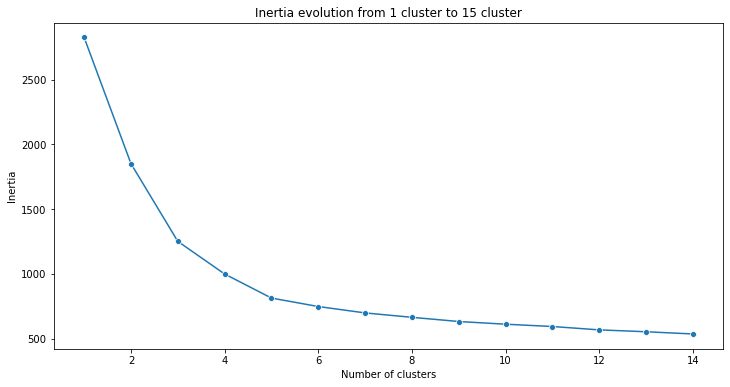

In [8]:
# elbow

max_k = 15
inertia = []

for k in range(1, max_k): 
    inertia.append(KMeans(n_clusters=k).fit(songs_x_norm).inertia_)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Inertia evolution from 1 cluster to {max_k} cluster')
sns.lineplot(x=range(1, max_k), y=inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

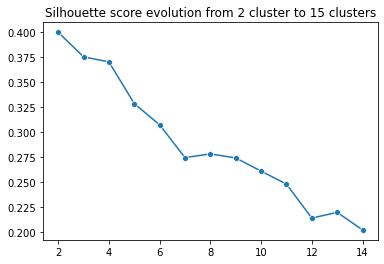

In [9]:
# silhouette
from sklearn.metrics import silhouette_score

max_k = 15
sil_score = []

data = songs_x_norm

for k in range(2, max_k): 
    labels = KMeans(n_clusters=k).fit(data).labels_
    sil_score.append(silhouette_score(data, labels))

plt.title(f'Silhouette score evolution from 2 cluster to {max_k} clusters')
sns.lineplot(x=range(2, max_k), y=sil_score, marker='o')
plt.show()

In [11]:
k = 5

# 1. import the model
from sklearn.cluster import KMeans
 
# 2. initialize the model
my_kmeans = KMeans(n_clusters= k) # choose number of clusters
 
# 3. fit the model to the data
my_kmeans.fit(songs_x_norm) # pass your scaled data here
 
# 4. obtain the cluster output
clusters = my_kmeans.predict(songs_x_norm) # pass your scaled data here
 
# 5. attach the cluster output to our original DataFrame
songs_x_norm["cluster"] = clusters

c:\Users\simon\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\simon\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [12]:
# centroids
centroids = pd.DataFrame(my_kmeans.cluster_centers_)
# centroids = songs_x_norm.groupby(by="cluster").mean()
centroids

,0,1,2,3,4,5,6,7,8,9
0,0.471236,0.825221,0.879021,0.103053,0.050524,0.050783,0.213973,0.289670,0.583622,1.000000e+00
1,0.728584,0.725751,0.871243,0.100813,0.165695,0.020569,0.180075,0.734481,0.557300,3.000000e+00
2,0.333387,0.135153,0.620077,0.049343,0.933982,0.869677,0.136670,0.172093,0.492074,2.000000e+00
3,0.543550,0.364979,0.780734,0.060480,0.746919,0.038273,0.185189,0.468388,0.535395,4.000000e+00
4,0.312136,0.892430,0.845632,0.108592,0.016877,0.799614,0.206249,0.263124,0.572050,1.776357e-14


# Write funtion to find 30 best (= nearest) songs for each playlist

In [13]:
# for each song
#    calculate eucledian distance to specific cluster-centroid
#       store result in column "distance"

for i in range(songs_x_norm.shape[0]):
  cluster = songs_x_norm['cluster'][i]
  sum_dist_square = 0
  for j in range(9):
    sum_dist_square += ((songs_x_norm[j][i]-centroids[j][cluster])**2)
  dist = np.sqrt(sum_dist_square)
  songs_x_norm.loc[i, 'distance'] = dist

songs_x_norm.sample(5)

# copy column cluster + distance to original Dataframe

df_5000_songs[['cluster', 'distance']] = songs_x_norm[['cluster', 'distance']]

df_5000_songs.head()

# make a pandasDateframe for each cluster with the 30 songs with smallest distance, name them playlist1 to playlist5
playlist_name = 'playlist'
for i in range(k):
  playlist_name = "playlist" + str(i+1)
  globals()[playlist_name] = df_5000_songs[df_5000_songs['cluster']==i].sort_values('distance', ascending=True).head(30)

playlist1

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster,distance
2663,Years - ラジオ・エディット ...,Alesso,0.370,0.823,2,-6.245,1,0.0805,0.002340,0.000002,0.1740,0.323,128.008,,195480,4,2YBnNbMOUUSkqncnQgkqST,https://open.spotify.com/track/2YBnNbMOUUSkqnc...,0,0.126865
2752,You're Gonna Love Again ...,NERVO,0.408,0.894,1,-5.209,0,0.0732,0.011100,0.017200,0.1350,0.275,125.976,,201307,4,214tNSr4epshNjQ6W2PTLg,https://open.spotify.com/track/214tNSr4epshNjQ...,0,0.129085
2346,Roots Bloody Roots ...,Sepultura,0.428,0.874,4,-6.664,0,0.1280,0.000337,0.041900,0.3110,0.261,119.708,,212253,4,6ursmCnbc9oDRGa2yHKkoZ,https://open.spotify.com/track/6ursmCnbc9oDRGa...,0,0.136463
2650,Heroes (we could be) ...,Alesso,0.516,0.749,5,-4.091,1,0.0692,0.031000,0.000000,0.2050,0.356,125.920,,209867,4,0VYQK5I08homNvX8SRS37R,https://open.spotify.com/track/0VYQK5I08homNvX...,0,0.140293
2943,Dreamer - Matisse & Sadko Remix ...,Axwell /\ Ingrosso,0.514,0.878,10,-4.498,1,0.0380,0.027100,0.000356,0.1420,0.249,125.988,,250810,4,6Bz6Rsp8GyeK4yL7APYYX3,https://open.spotify.com/track/6Bz6Rsp8GyeK4yL...,0,0.142391
2702,Ten Feet Tall ...,Afrojack,0.523,0.861,0,-3.447,1,0.0644,0.033600,0.000000,0.1440,0.346,127.049,,229149,4,2ldAdghnrO34HPcZ0IWfTu,https://open.spotify.com/track/2ldAdghnrO34HPc...,0,0.142972
713,Heroes (we could be) ...,Alesso,0.519,0.750,5,-4.153,1,0.0554,0.036400,0.000000,0.2120,0.366,125.859,,209867,4,77sHtGTWrw6FyUHCLlssle,https://open.spotify.com/track/77sHtGTWrw6FyUH...,0,0.149193
2842,Sun Is Never Going Down (feat. Dawn Golden) ...,Martin Garrix,0.506,0.726,5,-5.964,0,0.0366,0.003080,0.000081,0.2660,0.266,128.044,,204418,4,1NKCqXjcYZ81Budit2CQMh,https://open.spotify.com/track/1NKCqXjcYZ81Bud...,0,0.158285
1339,Where The Streets Have No Name - Remastered ...,U2,0.490,0.724,2,-9.581,1,0.0366,0.009760,0.004600,0.1590,0.292,125.812,,337506,4,4qgZs0RNjdzKAS22lP0QjY,https://open.spotify.com/track/4qgZs0RNjdzKAS2...,0,0.159379
3752,God of Emptiness ...,Morbid Angel,0.419,0.864,6,-10.107,1,0.0800,0.005030,0.028000,0.3210,0.232,118.192,,326933,4,2Nk68SHgYc6rpAmYCfohe2,https://open.spotify.com/track/2Nk68SHgYc6rpAm...,0,0.162368


## Initialize Spotify API

In [14]:
username = '<your-username>'
scope = "user-follow-modify playlist-modify-private user-library-read"
client_id="<your-client-id"
client_secret="<your-client-secret>"
redirect_uri = 'http://localhost:8888/callback' # you need too add this link to your spotify app that you created on the dev website (https://developer.spotify.com/dashboard/) Edit settings -> Redirect URIs

In [15]:
token = util.prompt_for_user_token(
        username=username,
        scope=scope,
        client_id=client_id,
        client_secret=client_secret,
        redirect_uri=redirect_uri)

sp = spotipy.Spotify(auth=token)

### Songs to add to our playlist

In [36]:
df_audio = playlist1

# add new column to create track_uri in the right format
df_audio = (
            df_audio
            .assign(track_uri = lambda s: 'spotify:track:' + df_audio['id'].str.rstrip())
            )

## Create an empty playlist on Spotify

In [38]:
playlist_name = 'playlist1'
my_playlist = sp.user_playlist_create(user=username, 
                                      name=playlist_name, 
                                      public=False, collaborative=False, 
                                      description='automatically generated playlist1')

## Add songs to the playlist

In [39]:
tracks = list(df_audio.track_uri)

In [40]:
for uri in tracks:
    my_uri = [uri]  # the uri has to be in a list
    sp.user_playlist_add_tracks(user=username, 
                                playlist_id=my_playlist['id'], 
                                tracks=my_uri,
                                position=None)